# Lab 02. 라벨 스무딩 적용 여부 비교 실습
---

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt 

from torchvision.transforms import ToTensor

c:\Users\kss34\anaconda3\envs\pytorchPractice\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 사용자 정의 손실 함수 (라벨 스무딩 적용 크로스 엔트로피)

In [2]:
class LabelSmothingLoss(nn.Module) :  # 사용자 정의 손실 함수 
    def __init__(self, num_classes, smothing=0.0) : 
        super(LabelSmothingLoss, self).__init__()
        self.num_classes = num_classes  # -> 분류 문제 : 클래스 개수 
        self.smothing = smothing        # -> 라벨 적용되는 스무딩 정도 제어 값 -> 기본 0.0, 스무딩 적용 x
        self.confidence = 1.0 - smothing  # -> Smoothing 보정값 (정답에 대한 신뢰도 점수)
        
    def forward(self, pred, target) : # pred : 예측값, target : 정답지 
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)    # 원-핫 인코딩 텐서 생성 
        smoth_label = one_hot * self.confidence + (1 - one_hot) * self.smothing / (self.num_classes - 1)
        # 원-핫 인코딩 텐서에서 라벨 스무딩을 적용 -> 신뢰도 점수 
        loss = torch.sum(-smoth_label * torch.log_softmax(pred, dim=1), dim=1)
        # 스무딩 처리된 라벨과 예측 확률간 교차 엔트로피 사용해서 loss 계산 -> log_softmax 확률과 라벨 스무딩 요소 곱을 통해 수행 
        
        return torch.mean(loss)    # 평균 손실 구해 주고 반환 

## 모델 정의 

In [3]:
class MyModel(nn.Module) : 
    def __init__(self) : 
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*5*5, 128)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x) :
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

## 데이터셋 로드 및 전처리 

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root="./F_data", train=True, transform=ToTensor(), download=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

## 모델 정의 

In [5]:
model = MyModel()

print(model)

MyModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu3): ReLU(inplace=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 옵티마이저 설정, Loss 함수 설정 

In [6]:
# 옵티마이저 설정 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 손실 함수 정의 
num_classes = 10
smoting = 0.2
no_criterion = LabelSmothingLoss(num_classes, smothing=0.0)
criterion = LabelSmothingLoss(num_classes, smoting)

##  학습 루프 

In [7]:
num_epochs = 20
train_losses_no_smothing = []
train_losses_smothing = []

for epoch in range(num_epochs) : 
    train_losses_no_smothing_temp = 0.0 
    train_losses_smothing_temp = 0.0
    
    for images, labels in train_dataloader :
        optimizer.zero_grad()
        
        # 라벨 스무딩을 적용 하지 않는 경우 
        outputs_no_smothing = model(images)
        loss_no_smothing = no_criterion(outputs_no_smothing, labels)
        loss_no_smothing.backward()
        optimizer.step()
        train_losses_no_smothing_temp += loss_no_smothing.item()
        
        # 라벨 스무딩을 적용한 경우 
        outputs_smothing = model(images)
        loss_smothing = criterion(outputs_smothing, labels)
        loss_smothing.backward()
        optimizer.step()
        train_losses_smothing_temp += loss_smothing.item()
        
    # 에포크 마다 손실 기록 
    train_losses_no_smothing.append(train_losses_no_smothing_temp / len(train_dataloader))
    train_losses_smothing.append(train_losses_smothing_temp / len(train_dataloader))

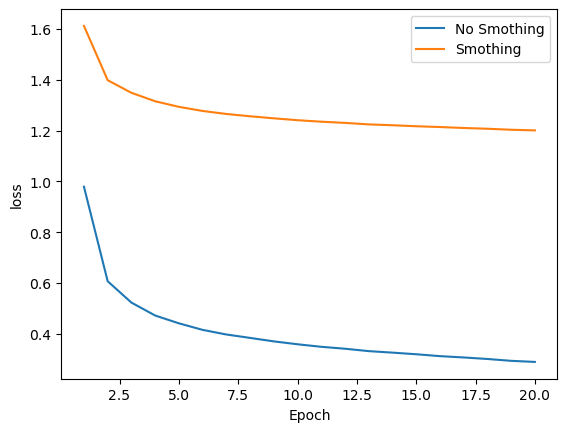

In [8]:
epochs = range(1, num_epochs +1 )

plt.plot(epochs, train_losses_no_smothing, label='No Smothing')
plt.plot(epochs, train_losses_smothing, label='Smothing')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()